# Final Wake Model
Training a model to predict roughly when I'll wake.

In [9]:
# %reload_ext autoreload
# %autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load model

In [25]:
from datetime import datetime
import xgboost as xgb
import os

best_model_filename = "models/minsUntilWake_xgboost_model.cbm"
loaded_model = xgb.XGBRegressor()
loaded_model.load_model(best_model_filename)

modification_time = os.path.getmtime(best_model_filename)
modification_date = datetime.fromtimestamp(modification_time)
modification_date_str = str(modification_date.date())

print(f"Modification date of {best_model_filename}: {modification_date}")

Modification date of models/minsUntilWake_xgboost_model.cbm: 2024-12-18 05:41:31.079470


# Load data

In [10]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [11]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)

df = stitch_pipeline_results.stitch_all_days_optimised(input_dir)

  0%|          | 0/121 [00:00<?, ?it/s]

C:\dev\play\brainwave-processor\stitch_pipeline_results.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return post_stitch(pd.concat(all_dfs), should_remove_days_per_questionnaire)
C:\dev\play\brainwave-processor\stitch_pipeline_results.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 190.5  190.   189.5 ... -425.  -425.5 -426. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[group.index, 'SSMinsUntilLongWake'] = (df.loc[first_long_wake_idx, 'Timestamp'] - df.loc[group.index, 'Timestamp']).dt.total_seconds() / 60


In [4]:
max_minsUntilWake_per_day = df.groupby('dayAndNightOf')['minsUntilWake'].max().reset_index()
max_minsUntilWake_per_day

,dayAndNightOf,minsUntilWake
0,2024-07-08,561.720607
1,2024-07-11,568.692282
2,2024-07-12,554.025857
3,2024-07-13,568.069598
4,2024-07-14,573.562526
...,...,...
83,2024-12-07,585.004665
84,2024-12-08,562.005089
85,2024-12-09,597.994824
86,2024-12-10,563.506160


In [28]:
merged = df[df['dayAndNightOf'] != '2024-08-26']

In [30]:
merged.head()

,Stage,Confidence,Epoch,Timestamp,Source,StageInt,Main_eeg_abspow,Main_eeg_abspow_c7min_norm,Main_eeg_abspow_p2min_norm,Main_eeg_alpha,...,SSPreReadyToSleep,SSAfterSleep,SSDuringReadyToSleep,SSAfterFinalWake,SSDuringSleep,SSWakeDuringSleep,SSDuringLongWake,SSMinsUntilLongWake,SSLongWakeThisNight,SSLongWakeThisNightAndIsBefore
0,W,0.998275,0,2024-07-11 22:46:18.463109016+01:00,F8-M1,0,6.953841e-10,1.665056,0.665430,0.018062,...,True,False,True,False,False,False,False,-1.0,False,False
1,W,0.999091,1,2024-07-11 22:46:48.463109016+01:00,O2-M1,0,7.733423e-10,1.698885,0.710340,0.020365,...,True,False,True,False,False,False,False,-1.0,False,False
2,W,0.999967,2,2024-07-11 22:47:18.463109016+01:00,O2-M1,0,3.587651e-09,1.757647,1.806133,0.008850,...,True,False,True,False,False,False,False,-1.0,False,False
3,W,0.999958,3,2024-07-11 22:47:48.463109016+01:00,O2-M1,0,1.609135e-09,1.714270,1.784149,0.017979,...,True,False,True,False,False,False,False,-1.0,False,False
4,W,0.999843,4,2024-07-11 22:48:18.463109016+01:00,O2-M1,0,2.370349e-09,1.664098,2.266597,0.011407,...,True,False,True,False,False,False,False,-1.0,False,False


# Prepare data

In [40]:
import sys
import final_wake_model
reload(final_wake_model)
from importlib import reload

models_and_data = final_wake_model.create_and_add_all(merged, False)

from models.final_wake.final_wake_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(md: ModelAndData):
    # X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.1, random_state=42)

    md.X_train = md.X.loc[merged.index[merged['dayAndNightOf'] < modification_date_str]]
    md.X_val = md.X.loc[merged.index[merged['dayAndNightOf'] >= modification_date_str]]
    md.y_train = md.y.loc[merged.index[merged['dayAndNightOf'] < modification_date_str]]
    md.y_val = md.y.loc[merged.index[merged['dayAndNightOf'] >= modification_date_str]]

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

CleanTargetCol (95889, 349) to (95889, 349)
Condition: before 95889 rows after 95889 rows
FeaturesHandler (95889, 349) to (95889, 349) Had 349 features, after filtering have 141 features, first index 0
RequireNonEmptyRows: before 95889 rows after 95889 rows
DropBadRows: before 95889 rows after 95889 rows
CleanTargetCol (95889, 349) to (95889, 349)
Condition: before 95889 rows after 95889 rows
FeaturesHandler (95889, 349) to (95889, 349) Had 349 features, after filtering have 141 features, first index 0
RequireNonEmptyRows: before 95889 rows after 95889 rows
DropBadRows: before 95889 rows after 95889 rows
Training set size minsUntilWakeSleepOnly: 83760, validation set size: 12129
Training set size minsUntilWake: 83760, validation set size: 12129


# Train XGBoost model

In [ ]:
import models.util.importances
reload(models.util.importances)

import models.util.rfe_training as training
reload(training)
import copy

import memory

memory.garbage_collect(print)

train_list = []
# train_list.append({"type": "XGBoost+HSTreeClassifierCV", "requireRemovedNan": True})
# train_list.append({"type": "ExplainableBoostingClassifier"})
# train_list.append({"type": "FIGSClassifier", "rfe": False})
train_list.append({"type": "XGBoost", "rfe": True})

for md in models_and_data:
    models = []
    for tl in train_list:
        if tl.get('requireRemovedNan', False) and not md.removed_nan:
            continue

        tl_copy = copy.deepcopy(tl)
        if (tl['type'] == 'XGBoost'):
            tl_copy['type'] = 'XGBoostClassifier' if md.is_classifier else 'XGBoostRegressor'
        if (tl['type'] == 'XGBoost+HSTreeClassifierCV'):
            tl_copy['type'] = 'XGBoostClassifier+HSTreeClassifierCV' if md.is_classifier else 'XGBoostRegressor+HSTreeRegressor'

        rfe = tl.get('rfe', False)
        models.extend(training.train_rfe(training.get_model, tl_copy, md.name, md.X_train, md.y_train, md.X_val, md.y_val, rfe))
    md.models = models

import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)
pd.set_option('display.max_columns', None)

display(evaluation.evaluate_regression_models(models_and_data))
display(evaluation.evaluate_classification_models(models_and_data))

Memory Usage: 2543.97 MB GC to 2543.97 MB
Training XGBoostRegressor model for minsUntilWakeSleepOnly with (83760, 140)... RMSE train: 40.607148962562206 RMSE val: 112.06452897023189


In [69]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_regression_models(modelsAndData)

,Rows_Train,MAE_Train,MAE_Val,MSE_Train,MSE_Val,RMSE_Train,RMSE_Val,Model,n_features
0,59512,27.379800573106174,43.522340527301346,1432.0800583054715,3874.3787871915065,37.842833645295,62.24450808859772,minsUntilWakeNeedTemp,134
1,59512,27.379800573106174,43.436001442371484,1432.0800583054715,3864.214299381413,37.842833645295,62.16280479017507,minsUntilWakeNeedTemp,67
2,59512,26.61540736184516,41.362891337894304,1377.587601251183,3469.5684687054268,37.1158672436895,58.90304294945573,minsUntilWakeNeedTemp,33
3,59512,27.016664565136427,39.98641523222786,1437.904661577186,3286.258684086257,37.919713363594745,57.32589889470776,minsUntilWakeNeedTemp,16
4,59512,31.801707622106303,43.274278387928746,2015.744207797885,3793.6979478099747,44.897040078360234,61.593002425681235,minsUntilWakeNeedTemp,12
5,59512,34.103810677258494,45.244733883823315,2337.934817099072,4164.9094203175855,48.352195576820215,64.53610942966415,minsUntilWakeNeedTemp,8
6,59512,38.701263096940515,50.0362389821064,3038.868042105395,5278.475658250523,55.1259289455098,72.65311870973278,minsUntilWakeNeedTemp,4


In [79]:
bm = modelsAndData[0].models[4]

# Evaluate the model

Evaluation for model:  minsUntilWakeNeedTemp
minsUntilWakeNeedTemp Training Set Evaluation:
MAE: 27.379800573106174, MSE: 1432.0800583054715, RMSE: 37.842833645295


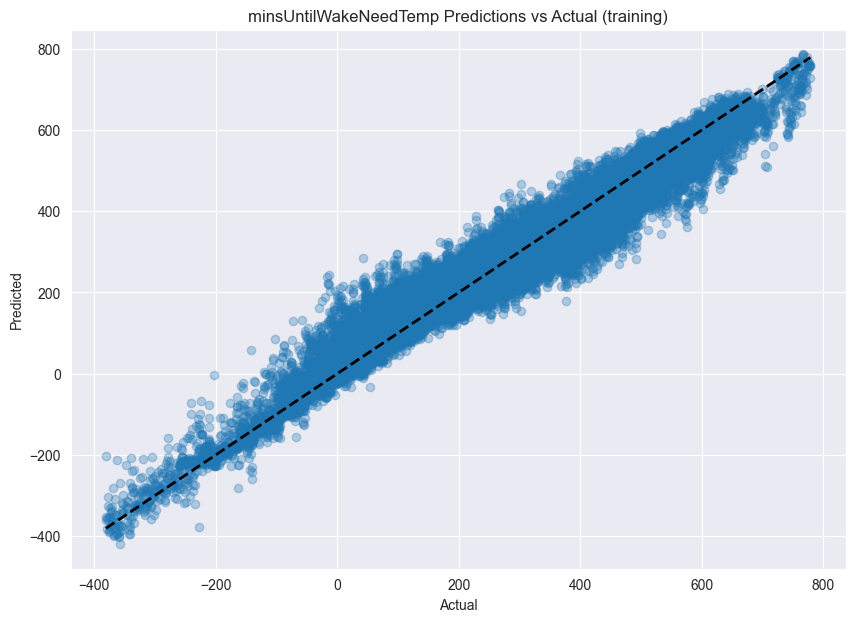

minsUntilWakeNeedTemp Validation Set Evaluation:
MAE: 43.522340527301346, MSE: 3874.3787871915065, RMSE: 62.24450808859772


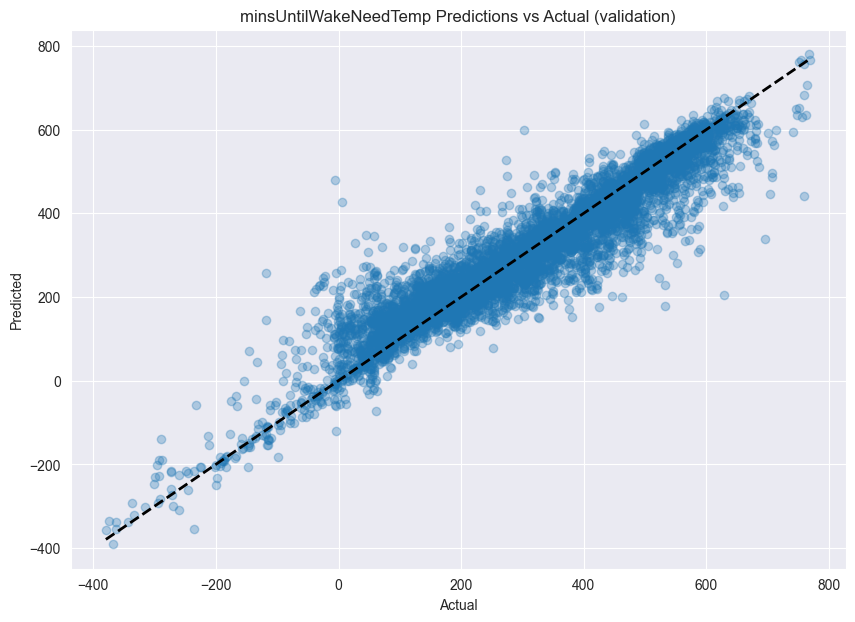

In [19]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

for md in modelsAndData:
    if md.is_classifier:
        evaluation.evaluate_classification_model(md, md.X_train, md.y_train, md.X_val, md.y_val)
    else:
        evaluation.evaluate_regression_model(md, md.X_train, md.y_train, md.X_val, md.y_val)

 # Save model


In [17]:
modelsAndData[0].X.columns

Index(['HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_c7min_norm_s',
       'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s',
       'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s',
       'Main_eeg_alpha_s', 'Main_eeg_alphaaa_c7min_norm_s',
       'Main_eeg_alphaaa_p2min_norm_s',
       ...
       'Main_eeg_thetaabs_s', 'Main_eeg_thetaabsaa_c7min_norm_s',
       'Main_eeg_thetaabsaa_p2min_norm_s', 'Main_eeg_thetaabsaa_s',
       'Main_eeg_thetaabsab_c7min_norm_s', 'Main_eeg_thetaabsab_p2min_norm_s',
       'Main_eeg_thetaabsab_s', 'Movement', 'O2', 'Temp'],
      dtype='object', length=134)

In [13]:
filenames = []

for md in modelsAndData:
    model_filename = f"models/{md.name}_xgboost_model.cbm"
    log(f"Saving model {md} to {model_filename}")
    md.model.save_model(model_filename)
    filenames.append(model_filename)

for fn in filenames:
    print(f"\"{fn}\",")

"models/minsUntilWake_xgboost_model.cbm",


C:\Users\graha\.conda\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [05:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# Most useful features

In [80]:
# Install SHAP if you haven't already
# !pip install shap

import shap
import xgboost as xgb

# Create a DMatrix for SHAP
# dmatrix = xgb.DMatrix(bm.X_train)

# Initialize the SHAP explainer
explainer = shap.Explainer(bm.model)

# Calculate SHAP values
shap_values = explainer(bm.X_train)



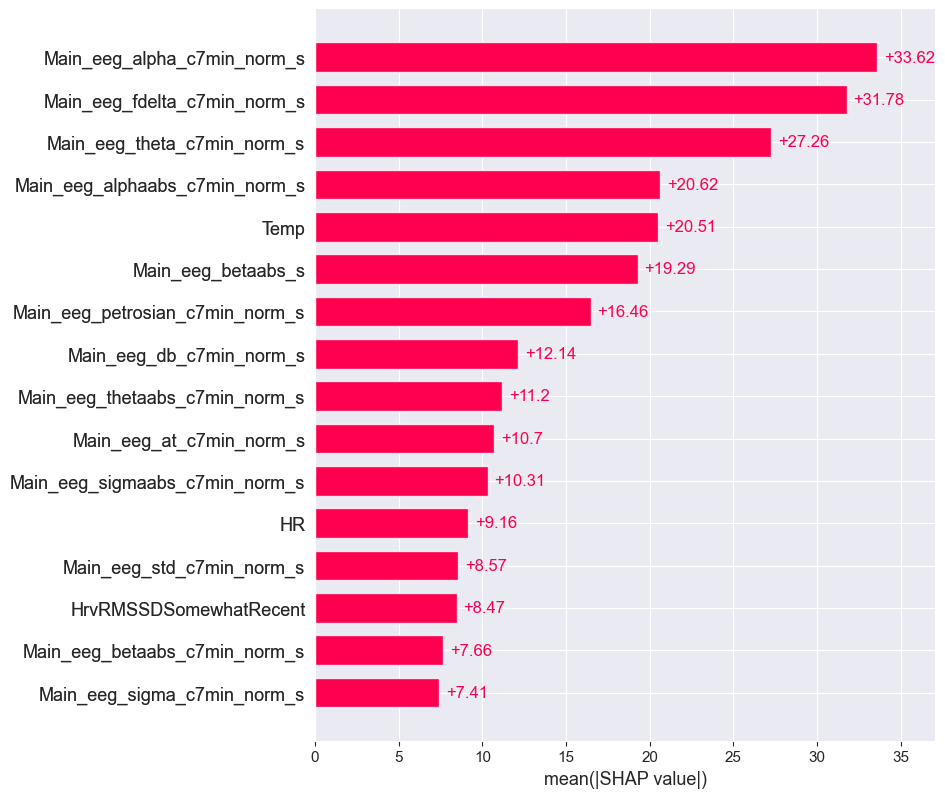

In [81]:
shap.plots.bar(shap_values, max_display=20)


In [130]:
shap_values.values

array([[-21.296297  ,   2.6384172 ,  -1.2477714 , ...,   3.6632063 ,
        -37.035133  ,  -8.199859  ],
       [-22.399448  ,  -6.798329  ,  -5.588598  , ...,  -3.2985816 ,
         -0.70692575, -13.691322  ],
       [-20.221285  ,   8.107731  ,  -2.9833364 , ...,   0.7689405 ,
         15.536229  ,  -4.975377  ],
       ...,
       [-19.75385   , -11.353025  ,  -2.863713  , ...,   2.6782238 ,
        -17.481829  , -10.596917  ],
       [-33.0773    ,   3.3882241 ,  -3.978356  , ...,  -4.005149  ,
         19.951302  ,  -9.110422  ],
       [-10.806415  ,   2.0753908 ,   7.0139    , ...,  -3.5174384 ,
          3.196974  ,  -9.700164  ]], dtype=float32)

In [82]:
shap_values.shape

(59512, 16)

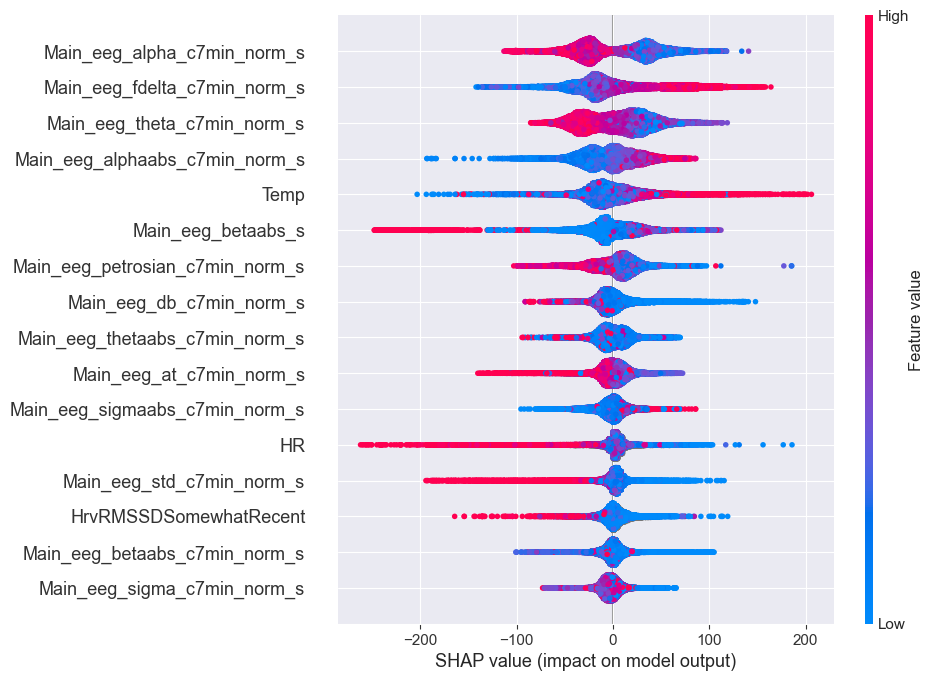

In [84]:
shap.plots.beeswarm(shap_values, max_display=20)


In [125]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Get the indices of the top 16 features
top_features_indices = np.argsort(mean_abs_shap_values)[-16:][::-1]

# Get the names of the top 16 features
top_features = [shap_values.feature_names[i] for i in top_features_indices]

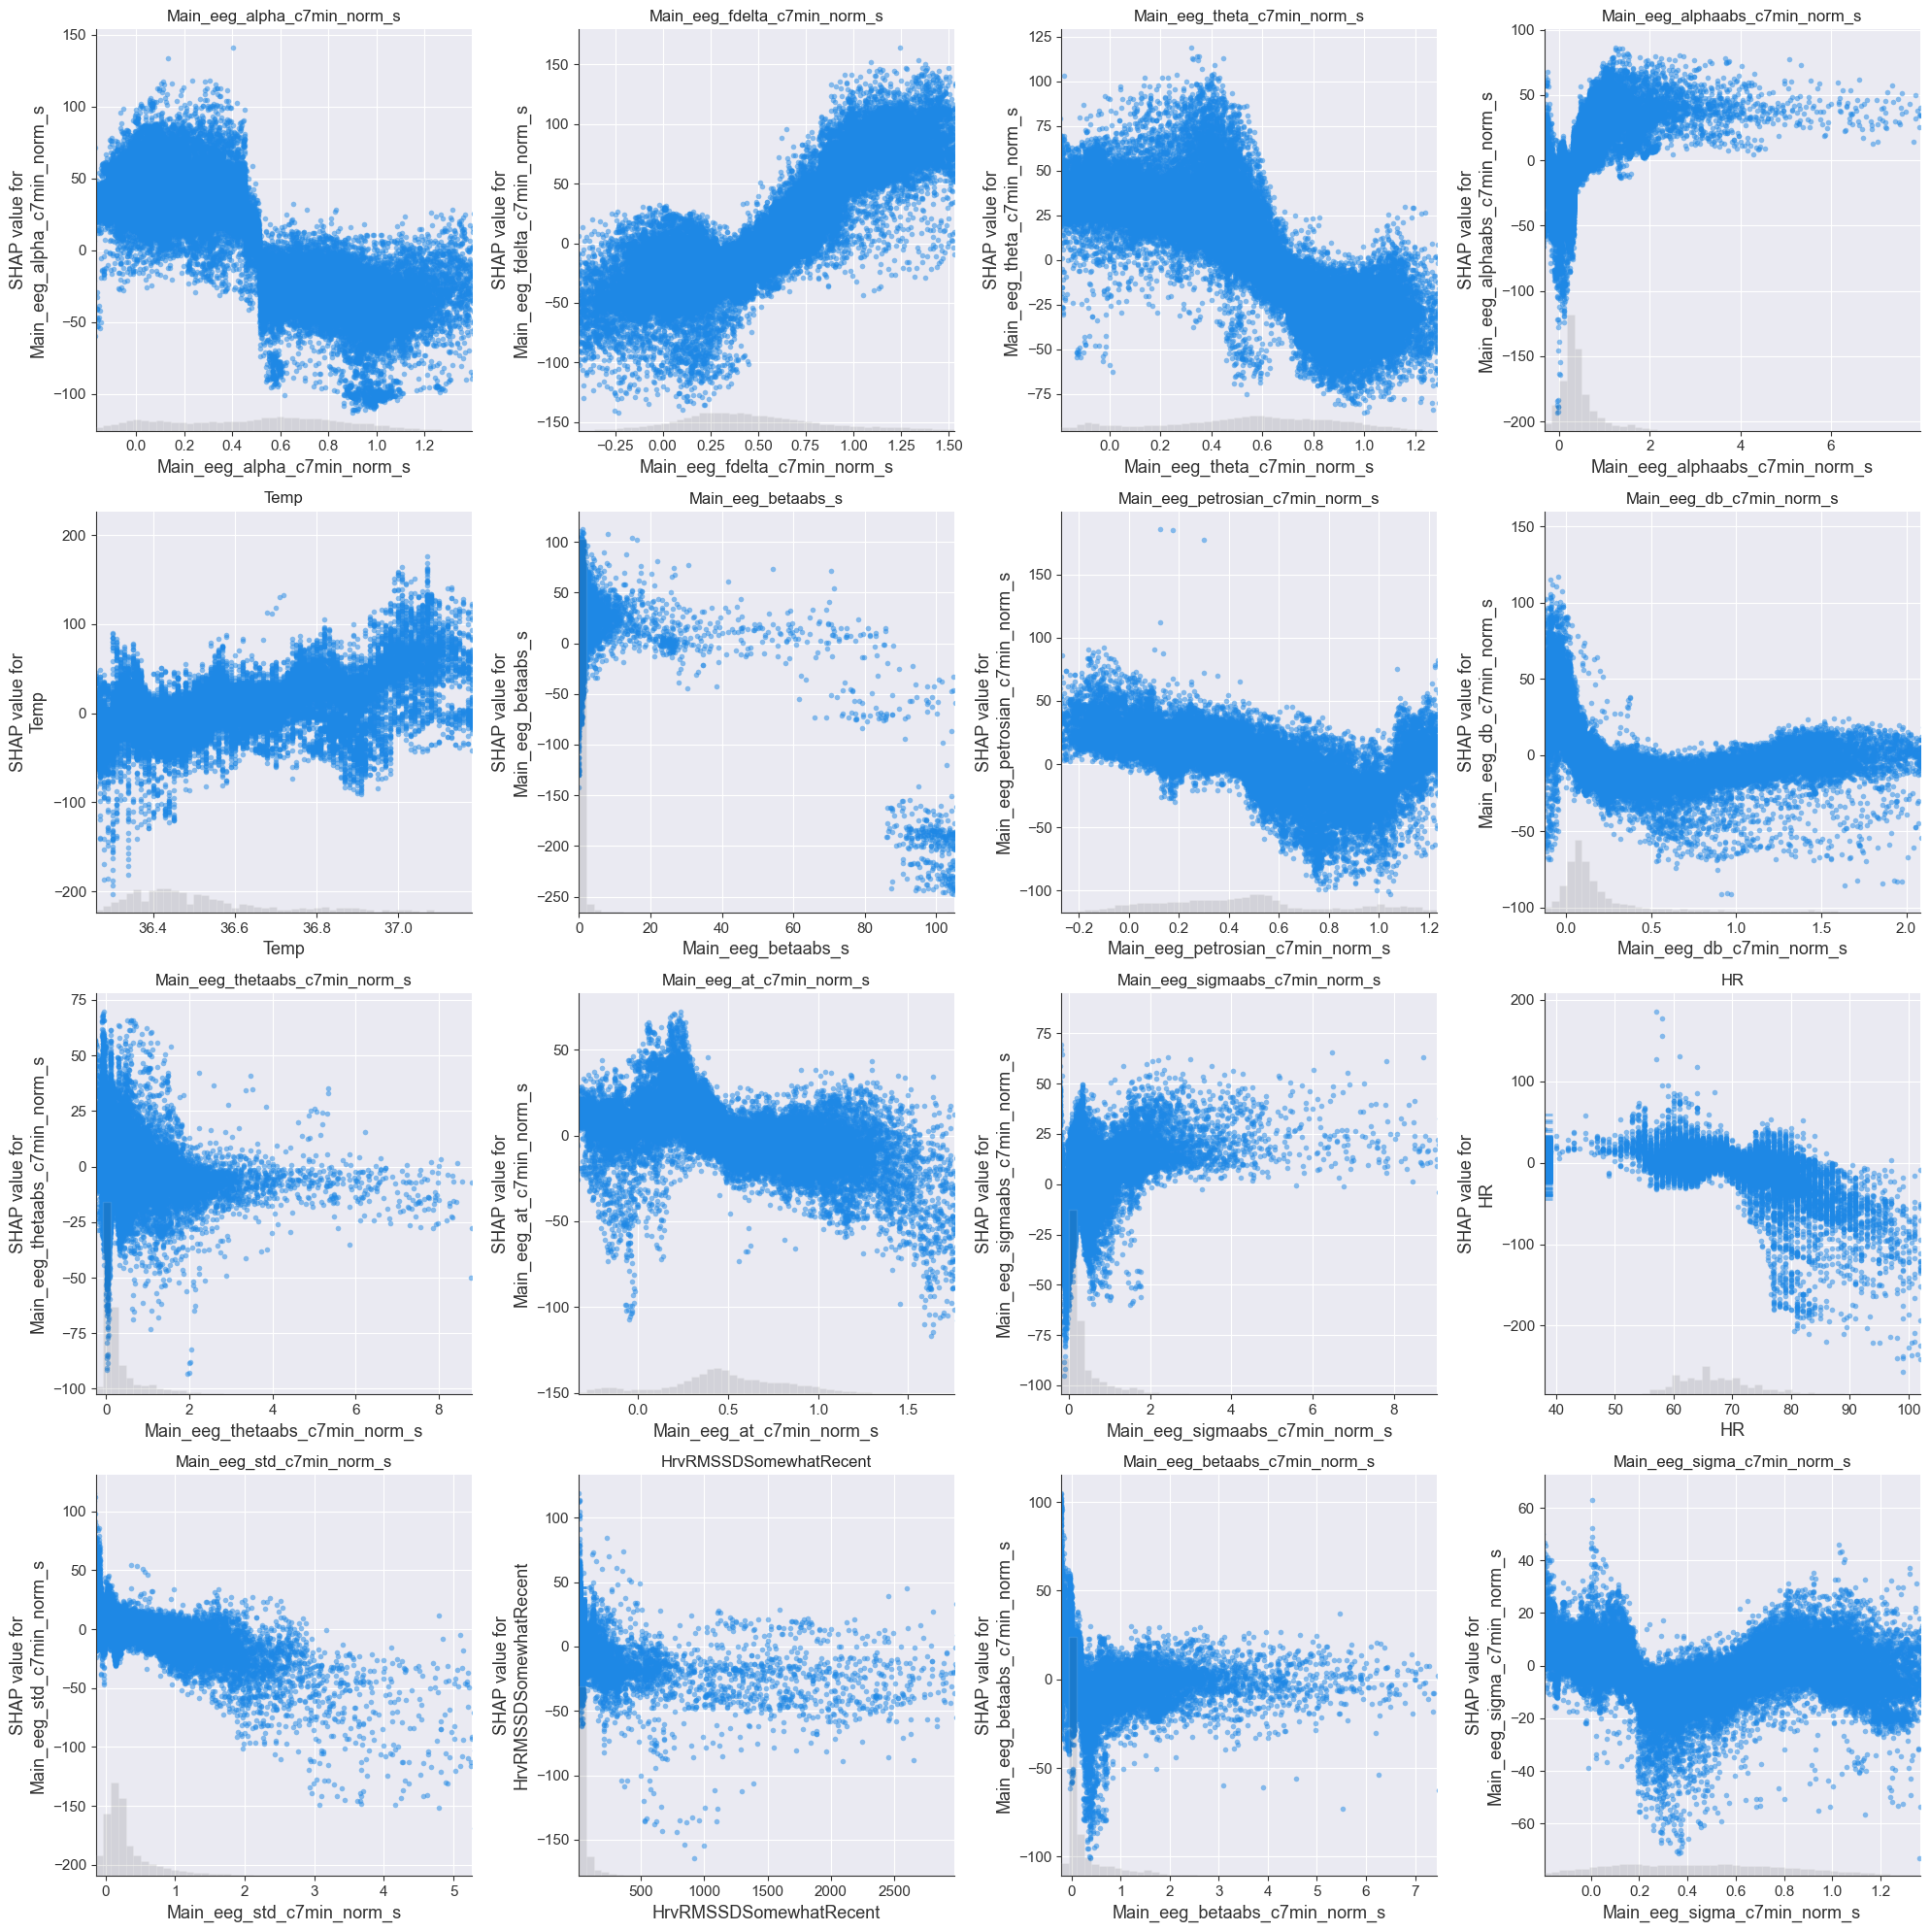

In [124]:
import matplotlib.pyplot as plt
import shap

# Create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(top_features):
    shap.plots.scatter(shap_values[:, feature], ax=axes[i], show=False, xmin='percentile(1)', xmax='percentile(99)', alpha=0.5)  # Avoid triggering plt.show()
    axes[i].set_title(feature)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [29]:
shap.dependence_plot(0, shap_values, modelsAndData[0].X_train)

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

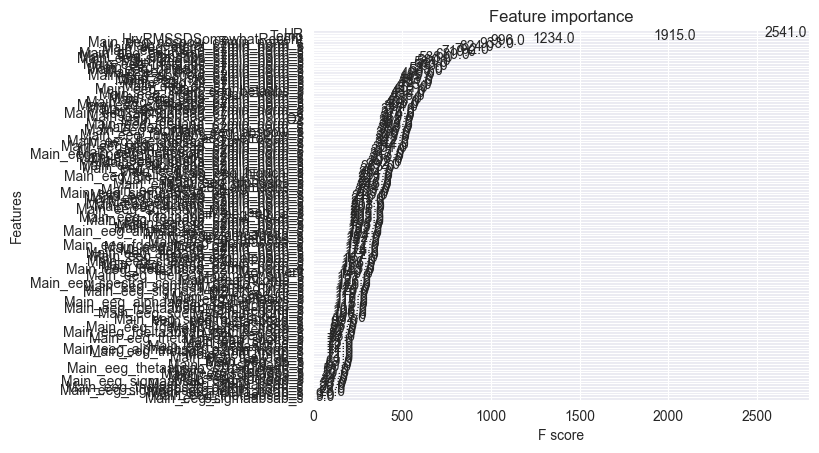

In [31]:
xgb.plot_importance(bm.model)

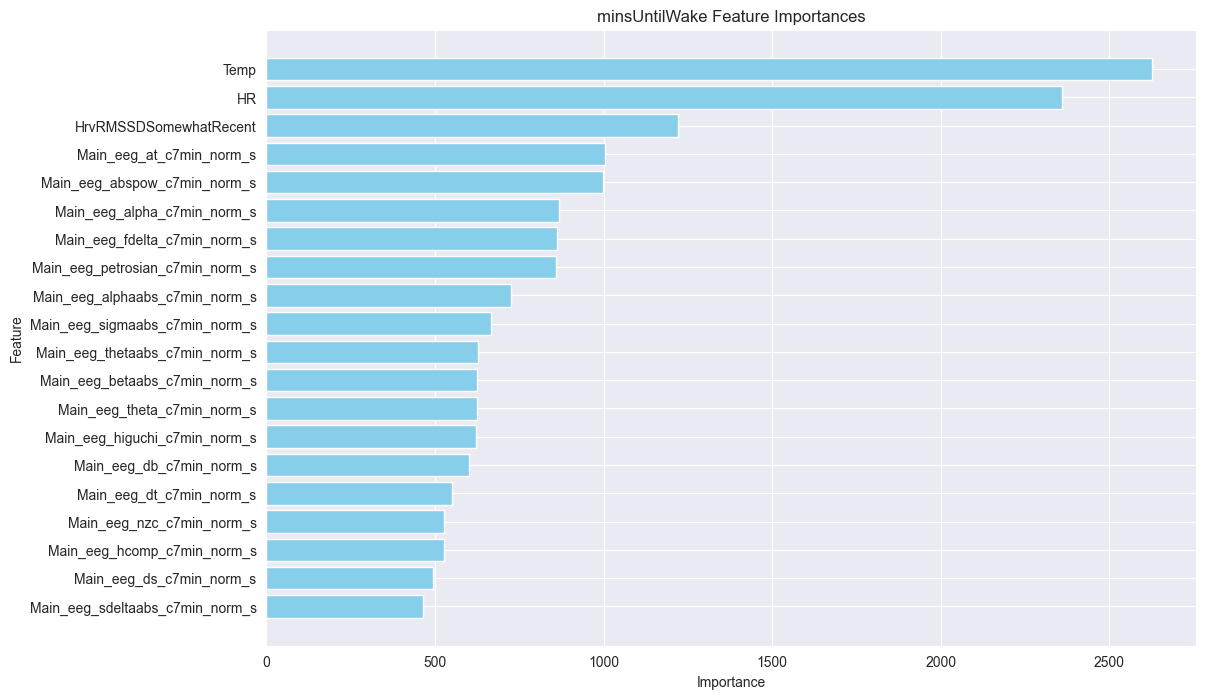

In [14]:
import models.util.importances as importances
from importlib import reload
reload(importances)
    
for md in modelsAndData:
    imp = importances.xgboost_importances(md)[0:20]
    importances.plot_importances(imp, md.name)

In [15]:
Ypetest_md = modelsAndData[0]

In [16]:
import seaborn as sns
sns.scatterplot(x='Main_eeg_perment_s', y=test_md.target_col, data=test_md.prepared_df)


NameError: name 'test_md' is not defined

In [75]:
test_md.prepared_df

,Confidence_x,F8-M1_Confidence_x,T4-M1_Confidence_x,O2-M1_Confidence_x,StageInt_x,Main_eeg_abspow_s,Main_eeg_abspow_c7min_norm_s,Main_eeg_abspow_p2min_norm_s,Main_eeg_alpha_s,Main_eeg_alpha_c7min_norm_s,...,Fpz-M1_Confidence_x,F4-M1_Confidence_x,Fpz-M1_Confidence_y,F4-M1_Confidence_y,SettlingEventMatchedIdx,SettlingManualScore,SettlingV4ManualScore,TiredVsAlertManualScore,SettlingV4ScorePrediction,WillWakeWithin60Mins
2,0.999987,0.999951,0.999987,0.999412,0,0.673643,0.631520,1.210844,0.074071,-0.139941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,0.999875,0.999564,0.999875,0.997296,0,0.740908,0.620911,1.136667,0.091764,-0.137007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,0.999843,0.998763,0.999843,0.996956,0,0.417889,0.609999,0.669285,0.161176,-0.133391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,0.999532,0.998831,0.999532,0.997687,0,0.577379,0.604815,0.731069,0.068022,-0.130382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,0.999465,0.998943,0.999465,0.987641,0,0.811312,0.654045,0.744720,0.098874,-0.120942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,0.999282,NaN,NaN,NaN,0,0.279018,1.278017,2.111404,0.099304,-0.030497,...,0.999282,NaN,0.999282,NaN,NaN,NaN,NaN,NaN,1.0,False
1145,0.997849,NaN,NaN,NaN,0,1.149445,1.162454,1.264398,-0.015355,-0.004882,...,0.997849,NaN,0.997849,NaN,NaN,NaN,NaN,NaN,1.0,False
1146,0.997343,NaN,NaN,NaN,0,0.348046,1.017307,0.871481,0.121749,0.027155,...,0.997343,NaN,0.997343,NaN,NaN,NaN,NaN,NaN,1.0,False
1147,0.998733,NaN,NaN,NaN,0,0.595378,0.870215,0.761752,0.069582,0.060004,...,0.998733,NaN,0.998733,NaN,NaN,NaN,NaN,NaN,1.0,False


<Axes: xlabel='TimeToReadyToSleepMins', ylabel='Main_eeg_perm_s'>

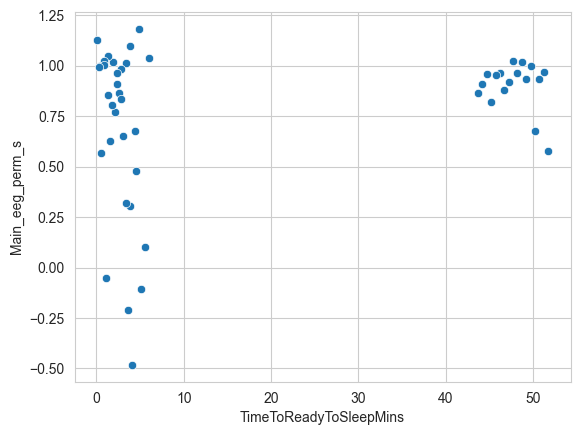

In [160]:
day1 =  test_md.prepared_df[0:48]
sns.scatterplot(y='Main_eeg_perm_s', x=target_cols[1], data=day1)


In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time_to_ready_to_sleep_mins=50):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2['TimeToReadyToSleepMins_int'] = df2['TimeToReadyToSleepMins'].astype(int)
    df2 = df2[df2['TimeToReadyToSleepMins_int'] <= max_time_to_ready_to_sleep_mins]

    # Group by the integer version of x and calculate the mean for each group
    grouped = df2.groupby('TimeToReadyToSleepMins_int').mean().reset_index()

    # Plot the average value for each integer version of x with a linear regression line
    sns.regplot(x='TimeToReadyToSleepMins_int', y=col_name, data=grouped, ax=ax, scatter_kws={'s': 10})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
columns_to_plot = correlations.index

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(test_md.prepared_df, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

KeyError: 'TimeToReadyToSleepMins'

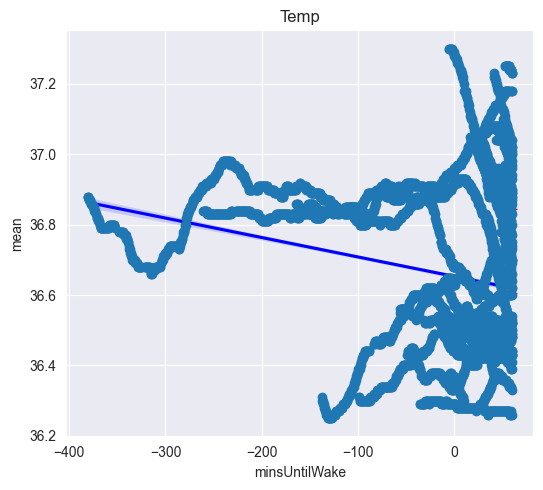

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time=60):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2 = df2[df2['minsUntilWake'] <= max_time]
    grouped = df2.groupby('minsUntilWake').agg({col_name: ['mean', 'std']}).reset_index()
    grouped.columns = ['minsUntilWake', 'mean', 'std']

    # Plot the average value for each integer version of x with error bars
    ax.errorbar(grouped['minsUntilWake'], grouped['mean'], yerr=grouped['std'], fmt='o', ecolor='r', capsize=5)
    sns.regplot(x='minsUntilWake', y='mean', data=grouped, ax=ax, scatter=False, line_kws={'color': 'blue'})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
# correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
# columns_to_plot = correlations.index
columns_to_plot = ['Temp']

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(merged, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

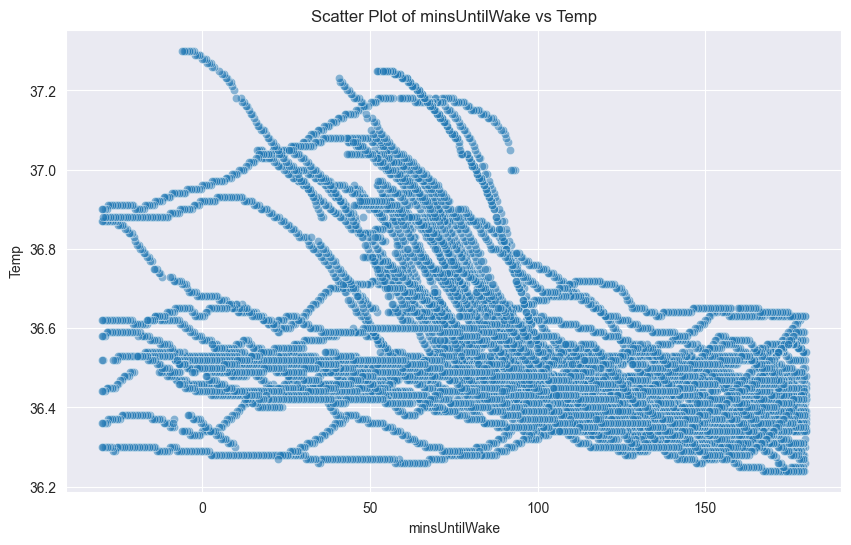

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for minsUntilWake <= 60
filtered_df = merged[(merged['minsUntilWake'] <= 180) & (merged['minsUntilWake'] >= -30)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minsUntilWake', y='Temp', data=filtered_df, alpha=0.5)
plt.title('Scatter Plot of minsUntilWake vs Temp')
plt.xlabel('minsUntilWake')
plt.ylabel('Temp')
plt.show()

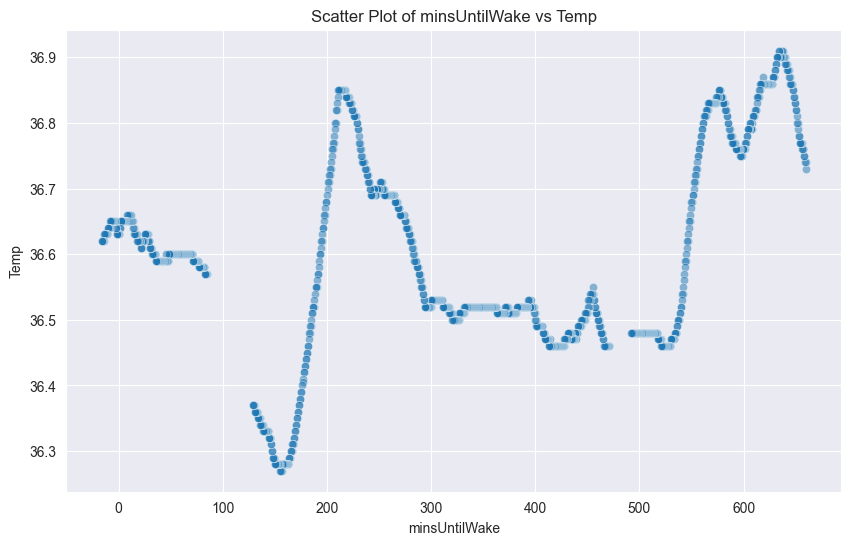

In [101]:
df = merged[merged['dayAndNightOf'] == '2024-12-05']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='minsUntilWake', y='Temp', data=df, alpha=0.5)
plt.title('Scatter Plot of minsUntilWake vs Temp')
plt.xlabel('minsUntilWake')
plt.ylabel('Temp')
plt.show()


# Check model against all days

In [20]:
import models.util.model_features
from models.util.model_features import get_model_feature_names
import final_wake_model
reload(final_wake_model)

def predict(model, df_in, output_col_prefix):
    df_out = df_in.copy()

    models_and_data_for_df = final_wake_model.create_and_add_all(df_in, True)
    feature_names = get_model_feature_names(model)
    # Hard-coding the best-model index isn't good..
    prediction_s = models_and_data_for_df[0].prepared_df[feature_names]
    preds = model.predict(prediction_s)

    df_out[output_col_prefix + 'Prediction'] = preds

    # Classifier
    if 'predict_proba' in dir(model):
        preds_proba = model.predict_proba(prediction_s)
        df_out[output_col_prefix + 'Probability'] = preds_proba[:, 1]

    return df_out


predictions_for_all_days = predict(loaded_model, df, "Test")

CleanTargetCol (95889, 352) to (95889, 352)
Condition: before 95889 rows after 95889 rows
FeaturesHandler (95889, 352) to (95889, 352) Had 352 features, after filtering have 132 features, first index 0
RequireNonEmptyRows: before 95889 rows after 95889 rows
DropBadRows: before 95889 rows after 95889 rows


KeyError: "['Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_at_c7min_norm_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_auc_c7min_norm_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_beta_c7min_norm_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_betaabs_c7min_norm_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_db_c7min_norm_s', 'Main_eeg_db_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_ds_c7min_norm_s', 'Main_eeg_ds_p2min_norm_s', 'Main_eeg_ds_s', 'Main_eeg_dt_c7min_norm_s', 'Main_eeg_dt_p2min_norm_s', 'Main_eeg_dt_s', 'Main_eeg_fdelta_c7min_norm_s', 'Main_eeg_fdelta_p2min_norm_s', 'Main_eeg_fdelta_s', 'Main_eeg_fdeltaaa_c7min_norm_s', 'Main_eeg_fdeltaaa_p2min_norm_s', 'Main_eeg_fdeltaaa_s', 'Main_eeg_fdeltaab_c7min_norm_s', 'Main_eeg_fdeltaab_p2min_norm_s', 'Main_eeg_fdeltaab_s', 'Main_eeg_fdeltaabs_c7min_norm_s', 'Main_eeg_fdeltaabs_p2min_norm_s', 'Main_eeg_fdeltaabs_s', 'Main_eeg_fdeltaabsaa_c7min_norm_s', 'Main_eeg_fdeltaabsaa_p2min_norm_s', 'Main_eeg_fdeltaabsaa_s', 'Main_eeg_fdeltaabsab_c7min_norm_s', 'Main_eeg_fdeltaabsab_p2min_norm_s', 'Main_eeg_fdeltaabsab_s', 'Main_eeg_hcomp_c7min_norm_s', 'Main_eeg_hcomp_p2min_norm_s', 'Main_eeg_hcomp_s', 'Main_eeg_higuchi_c7min_norm_s', 'Main_eeg_higuchi_p2min_norm_s', 'Main_eeg_higuchi_s', 'Main_eeg_hmob_c7min_norm_s', 'Main_eeg_hmob_p2min_norm_s', 'Main_eeg_hmob_s', 'Main_eeg_iqr_c7min_norm_s', 'Main_eeg_iqr_p2min_norm_s', 'Main_eeg_iqr_s', 'Main_eeg_nzc_c7min_norm_s', 'Main_eeg_nzc_p2min_norm_s', 'Main_eeg_nzc_s', 'Main_eeg_petrosian_c7min_norm_s', 'Main_eeg_petrosian_p2min_norm_s', 'Main_eeg_petrosian_s', 'Main_eeg_sdelta_c7min_norm_s', 'Main_eeg_sdelta_p2min_norm_s', 'Main_eeg_sdelta_s', 'Main_eeg_sdeltaabs_c7min_norm_s', 'Main_eeg_sdeltaabs_p2min_norm_s', 'Main_eeg_sdeltaabs_s', 'Main_eeg_sigma_c7min_norm_s', 'Main_eeg_sigma_p2min_norm_s', 'Main_eeg_sigma_s', 'Main_eeg_sigmaaa_c7min_norm_s', 'Main_eeg_sigmaaa_p2min_norm_s', 'Main_eeg_sigmaaa_s', 'Main_eeg_sigmaab_c7min_norm_s', 'Main_eeg_sigmaab_p2min_norm_s', 'Main_eeg_sigmaab_s', 'Main_eeg_sigmaabs_c7min_norm_s', 'Main_eeg_sigmaabs_p2min_norm_s', 'Main_eeg_sigmaabs_s', 'Main_eeg_sigmaabsaa_c7min_norm_s', 'Main_eeg_sigmaabsaa_p2min_norm_s', 'Main_eeg_sigmaabsaa_s', 'Main_eeg_sigmaabsab_c7min_norm_s', 'Main_eeg_sigmaabsab_p2min_norm_s', 'Main_eeg_sigmaabsab_s', 'Main_eeg_specent_c7min_norm_s', 'Main_eeg_specent_p2min_norm_s', 'Main_eeg_specent_s', 'Main_eeg_spectral_centroid_c7min_norm_s', 'Main_eeg_spectral_centroid_p2min_norm_s', 'Main_eeg_spectral_centroid_s', 'Main_eeg_std_c7min_norm_s', 'Main_eeg_std_p2min_norm_s', 'Main_eeg_std_s', 'Main_eeg_theta_c7min_norm_s', 'Main_eeg_theta_p2min_norm_s', 'Main_eeg_theta_s', 'Main_eeg_thetaaa_c7min_norm_s', 'Main_eeg_thetaaa_p2min_norm_s', 'Main_eeg_thetaaa_s', 'Main_eeg_thetaab_c7min_norm_s', 'Main_eeg_thetaab_p2min_norm_s', 'Main_eeg_thetaab_s', 'Main_eeg_thetaabs_c7min_norm_s', 'Main_eeg_thetaabs_p2min_norm_s', 'Main_eeg_thetaabs_s', 'Main_eeg_thetaabsaa_c7min_norm_s', 'Main_eeg_thetaabsaa_p2min_norm_s', 'Main_eeg_thetaabsaa_s', 'Main_eeg_thetaabsab_c7min_norm_s', 'Main_eeg_thetaabsab_p2min_norm_s', 'Main_eeg_thetaabsab_s'] not in index"

NameError: name 'final_wake_model' is not defined

In [44]:
merged_all_days_grouped = predictions_for_all_days.groupby('dayAndNightOf').agg(
    EnergyScorePrediction=('EnergyScorePrediction', 'mean'),
).reset_index()
all_days_grouped = grouped.merge(merged_all_days_grouped, on='dayAndNightOf', how='left')
# all_days_grouped
all_days_grouped['EnergyPredictionError'] = all_days_grouped['EnergyActual'] - all_days_grouped['EnergyScorePrediction']
all_days_grouped['EnergyPredictionErrorAbs'] = all_days_grouped['EnergyPredictionError'].abs()
all_days_grouped

,dayAndNightOf,EnergyActual,EnergyScorePrediction,EnergyPredictionError,EnergyPredictionErrorAbs
0,2024-07-11,100.000000,90.771431,9.228569,9.228569
1,2024-07-12,20.000000,28.509508,-8.509508,8.509508
2,2024-07-15,80.000000,80.228958,-0.228958,0.228958
3,2024-07-16,100.000000,97.707558,2.292442,2.292442
4,2024-07-17,20.000000,22.446157,-2.446157,2.446157
...,...,...,...,...,...
75,2024-12-21,14.018994,15.703000,-1.684006,1.684006
76,2024-12-27,18.945894,29.937300,-10.991406,10.991406
77,2024-12-28,31.122444,30.336603,0.785841,0.785841
78,2024-12-29,24.654361,30.936911,-6.282550,6.282550
